# **CNN with Data Augmentation and Transfer Learning**

*Objective: Enhance CNN performance using data augmentation and transfer learning techniques.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K
import seaborn as sns

2024-10-01 15:39:45.799663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 15:39:46.441554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## **Load Dataset and Data Preprocessing**

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3), Testing labels shape: (10000, 1)


In [3]:
# normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encoding
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test,num_classes)
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [4]:
# split training and validation
x_train_aug, x_val, y_train_aug, y_val = train_test_split(x_train, y_train, test_size=0.2)

#data augmentation
def resize_images(image):
  return tf.image.resize(image, [32, 32])

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

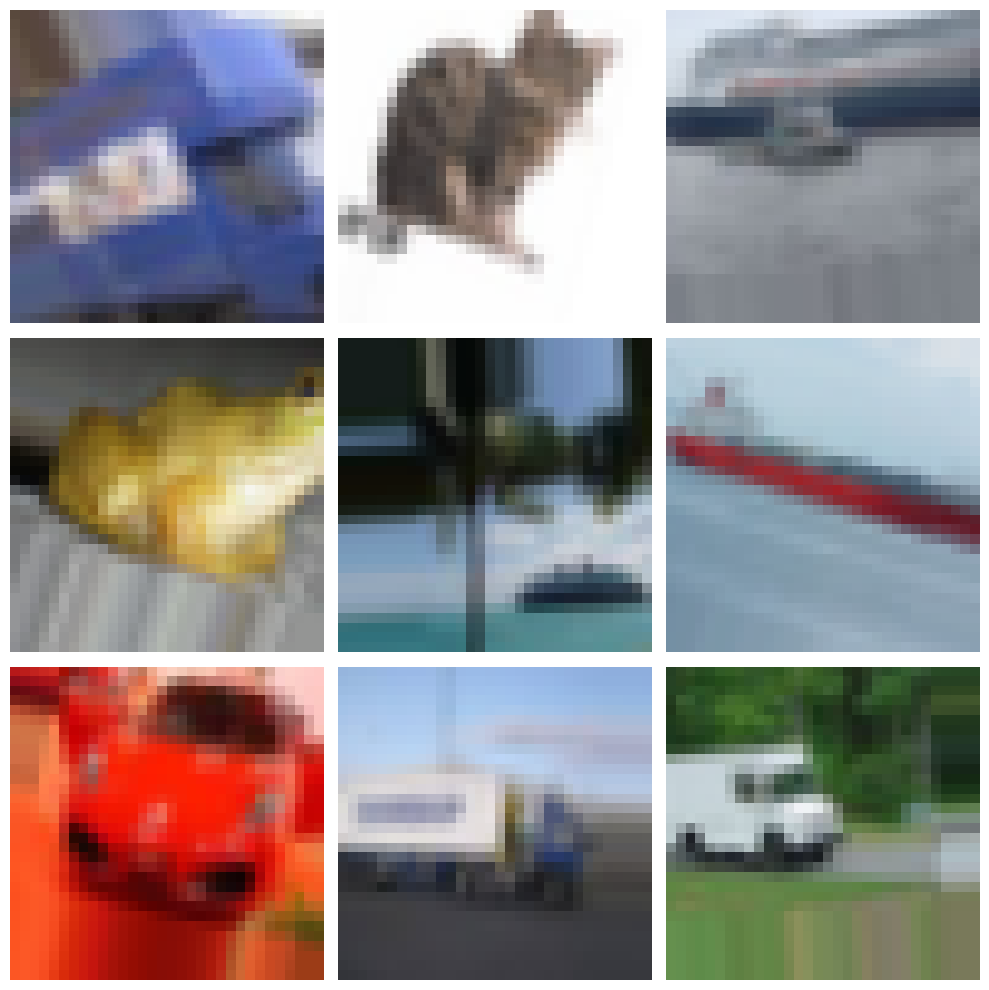

In [5]:
# parameters
batch_size = 64
train_generator = train_datagen.flow(
    x_train_aug, y_train_aug,
    batch_size=batch_size,
)

val_generator = val_datagen.flow(
    x_val, y_val,
    batch_size=batch_size,
)

# example from augmentation
def visualize(generator, num_images=9):
  augmented_images, _ = next(generator)

  plt.figure(figsize=(10, 10))
  for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

visualize(train_generator)

## **Transfer Learning**

In [6]:
# implement resnet
import tensorflow as tf
from tensorflow.keras import layers, optimizers, Model
from tensorflow.keras.applications import ResNet50

input_shape = (32, 32, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2024-10-01 15:39:49.469154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9008 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:42:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

## **Initial Training**: training top layers

In [7]:
# train model initial
epochs_initial = 10
with tf.device('/GPU:0'):
    history_initial = model.fit(
        train_generator,
        epochs=epochs_initial,
        validation_data=val_generator,
        steps_per_epoch=len(x_train_aug) // batch_size,
        validation_steps=len(x_val) // batch_size
    )

Epoch 1/10


2024-10-01 15:39:51.331363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-10-01 15:39:53.661668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-10-01 15:39:54.187067: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fdaa81a2750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-01 15:39:54.187106: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-01 15:39:54.192481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 15:39:54.

624/625 [============================>.] - ETA: 0s - loss: 2.3064 - accuracy: 0.1446

2024-10-01 15:40:12.432745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 23s 32ms/step - loss: 2.3063 - accuracy: 0.1447 - val_loss: 2.1349 - val_accuracy: 0.2238
Epoch 2/10
625/625 [==============================] - 19s 31ms/step - loss: 2.1961 - accuracy: 0.1690 - val_loss: 2.1312 - val_accuracy: 0.2327
Epoch 3/10
625/625 [==============================] - 19s 31ms/step - loss: 2.1765 - accuracy: 0.1754 - val_loss: 2.1114 - val_accuracy: 0.2369
Epoch 4/10
625/625 [==============================] - 20s 32ms/step - loss: 2.1841 - accuracy: 0.1779 - val_loss: 2.0735 - val_accuracy: 0.2491
Epoch 5/10
625/625 [==============================] - 20s 31ms/step - loss: 2.1634 - accuracy: 0.1838 - val_loss: 2.0546 - val_accuracy: 0.2724
Epoch 6/10
625/625 [==============================] - 20s 32ms/step - loss: 2.1621 - accuracy: 0.1848 - val_loss: 2.0266 - val_accuracy: 0.2724
Epoch 7/10
625/625 [==============================] - 20s 32ms/step - loss: 2.1508 - accuracy: 0.1887 - val_loss: 2.0294 - val_accuracy: 0.2701
Epo

## **Fine Training**

In [8]:
# fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# run model
epochs_fine = 20
with tf.device('/GPU:0'):
    history_fine = model.fit(
        train_generator,
        epochs=epochs_fine,
        steps_per_epoch=len(x_train_aug) // batch_size,
        validation_steps=len(x_val) // batch_size
    )

Epoch 1/20


2024-10-01 15:43:11.138237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 28s 28ms/step - loss: 2.6810 - accuracy: 0.1492
Epoch 2/20
625/625 [==============================] - 18s 29ms/step - loss: 2.3089 - accuracy: 0.1886
Epoch 3/20
625/625 [==============================] - 18s 28ms/step - loss: 2.2049 - accuracy: 0.2115
Epoch 4/20
625/625 [==============================] - 17s 28ms/step - loss: 2.1311 - accuracy: 0.2360
Epoch 5/20
625/625 [==============================] - 18s 28ms/step - loss: 2.0877 - accuracy: 0.2471
Epoch 6/20
625/625 [==============================] - 18s 28ms/step - loss: 2.0470 - accuracy: 0.2654
Epoch 7/20
625/625 [==============================] - 18s 28ms/step - loss: 2.0217 - accuracy: 0.2733
Epoch 8/20
625/625 [==============================] - 17s 28ms/step - loss: 1.9908 - accuracy: 0.2863
Epoch 9/20
625/625 [==============================] - 18s 28ms/step - loss: 1.9508 - accuracy: 0.3003
Epoch 10/20
625/625 [==============================] - 17s 28ms/step - loss: 1.9297 - accurac

In [9]:
# save model
best_model = model

# evaluate model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')



313/313 - 4s - loss: 2.0501 - accuracy: 0.3016 - 4s/epoch - 13ms/step
Test accuracy: 0.3016
Test loss: 2.0501


157/157 [==============================] - 2s 8ms/step
ROC AUC scores for each class: [0.830948   0.86506722 0.76608078 0.71509456 0.76374478 0.81493222
 0.79952833 0.86551344 0.83314367 0.86797978]


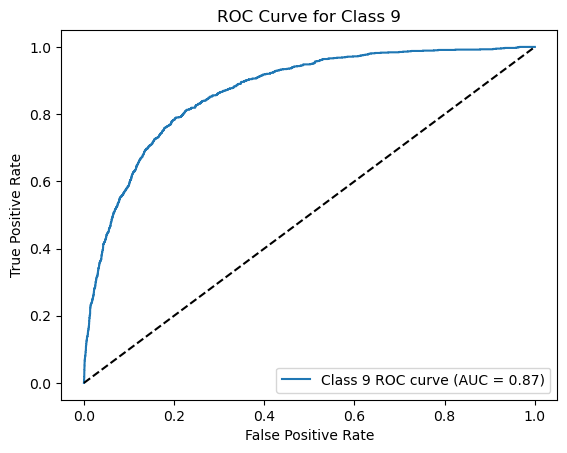

In [10]:
y_test_labels = np.argmax(y_test, axis=1) 
y_test_bin = label_binarize(y_test_labels, classes=range(num_classes))  
y_pred_prob = best_model.predict(x_test, batch_size=64, verbose=1)

# ROC area under the curve
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average=None, multi_class='ovr')
print(f'ROC AUC scores for each class: {roc_auc}')

# ROC curve
class_idx = 9  # Change this to plot other classes
fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_pred_prob[:, class_idx])

plt.figure()
plt.plot(fpr, tpr, label=f'Class {class_idx} ROC curve (AUC = {roc_auc[class_idx]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Class {class_idx}')
plt.legend(loc='lower right')
plt.show()


313/313 [==============================] - 3s 8ms/step


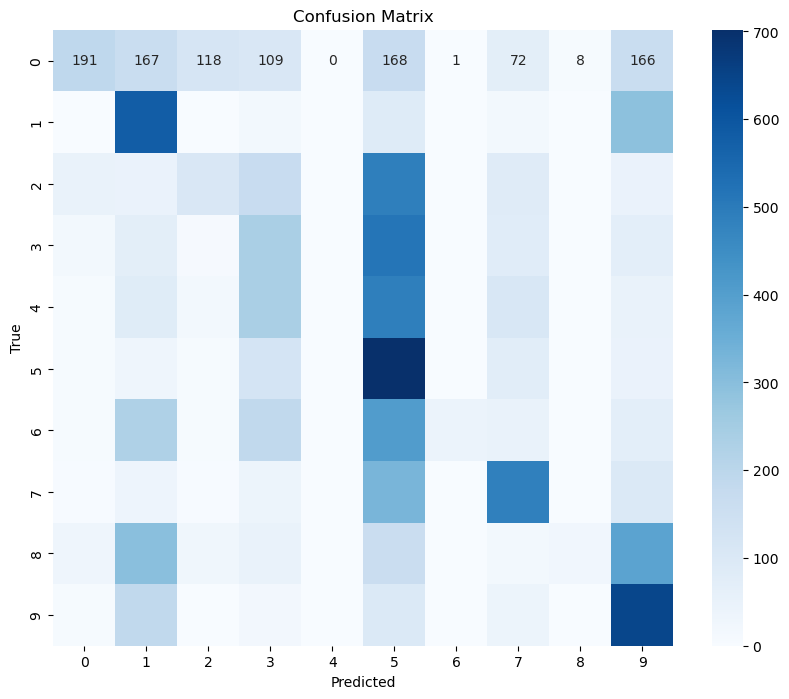

In [11]:
y_pred_classes = np.argmax(best_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

# confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes), 
            yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
# baseline model
def create_baseline_model(input_shape, num_classes):
    baseline = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return baseline

baseline_model = create_baseline_model(input_shape, num_classes)

# compile
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

# train without augmentation
epochs_baseline = 20

history_baseline = baseline_model.fit(
    x_train_aug, y_train_aug,
    epochs=epochs_baseline,
    validation_data=(x_val, y_val),
    batch_size=64,
    verbose=2
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0

In [13]:
baseline_loss, baseline_acc = baseline_model.evaluate(x_test, y_test, verbose=2)
print(f'Baseline Test accuracy: {baseline_acc:.4f}')
print(f'Baseline Test loss: {baseline_loss:.4f}')

313/313 - 1s - loss: 0.9393 - accuracy: 0.7184 - 795ms/epoch - 3ms/step
Baseline Test accuracy: 0.7184
Baseline Test loss: 0.9393


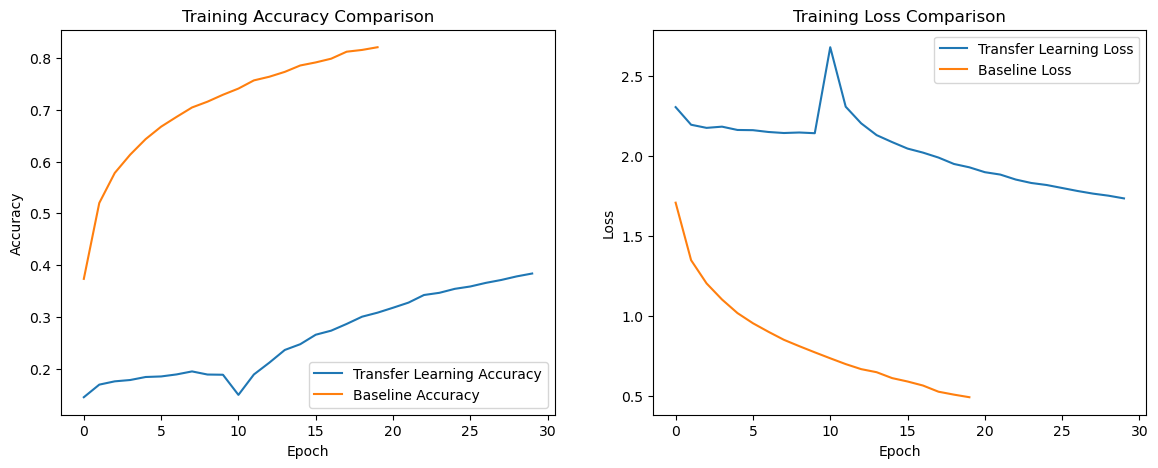


Final Test Accuracy with Transfer Learning: 0.3016
Final Test Accuracy without Transfer Learning (Baseline): 0.7184


In [17]:
# training and validation accuracy
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history_initial.history['accuracy'] + history_fine.history['accuracy'], label='Transfer Learning Accuracy')
plt.plot(history_baseline.history['accuracy'], label='Baseline Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# training and validation loss
plt.subplot(1,2,2)
plt.plot(history_initial.history['loss'] + history_fine.history['loss'], label='Transfer Learning Loss')
plt.plot(history_baseline.history['loss'], label='Baseline Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"\nFinal Test Accuracy with Transfer Learning: {test_acc:.4f}")
print(f"Final Test Accuracy without Transfer Learning (Baseline): {baseline_acc:.4f}")

We can observe these results where the final test accuracy with Transfer learning is at 30.16% and without transfer learning (baseline) is at 71.84%. This is a large discrepancy, but we can systematically diagnose what could be the causing issues. From the web, ResNet50/Imagenet set of images usually expects size images of 224x224. The CIFAR-10 dataset only offers images sizes of 32x32. 

This is a image size mismatch which could cause performance issues specifically like excessive downsampling. These are specifically small images when ResNet50 expect much larger images. This could cause the collapsing to single pixels. I tried resizing to 224x224, however I was facing a lot of issues, and I was on a time crunch. Given this, if resized properly, the transfer learning model may have better accuracy than the baseline. 
